In [21]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

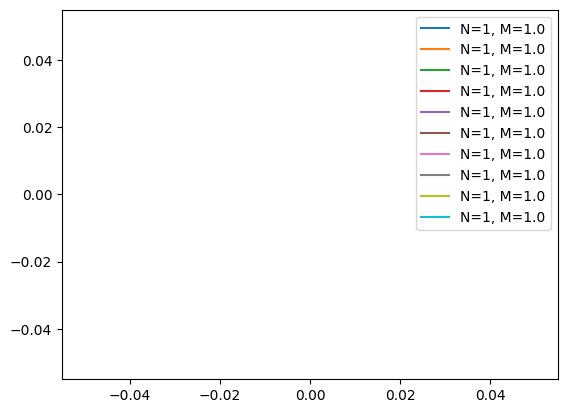

In [101]:
deltas = jnp.array(
    [1 / 100, 1 / 90, 1 / 80, 1 / 70, 1 / 60, 1 / 50, 1 / 40, 1 / 30, 1 / 20, 1 / 10])  #
Ndeltas = jnp.ceil(1 / deltas)
Mdeltas = jnp.ones((len(deltas),)) * 1_00
Mdeltas = jnp.ones((len(deltas),))
Mdeltas = jnp.ceil(1 / jnp.sqrt(deltas))

fineDeltas = jnp.ceil(1 / deltas**2)
Mdeltas = jnp.ones((len(deltas),))
Ndeltas = jnp.ones((len(deltas), ))
solver= "ekf0"
prefix = "IBM"+solver
folder = "./"
for n in range(len(Ndeltas)):
    N = Ndeltas[n]
    delta = deltas[n]
    M = Mdeltas[n]
    fine = fineDeltas[n]
    N = int(N)
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}.0_{M}.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}.0_{fine}.npy')
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    ts = jnp.linspace(0, 1, N)
    ranged = range(N)
    plt.plot(ts, -jnp.log(jnp.mean(jnp.linalg.norm(paths_1 - paths_2, axis=-1), axis=0)) / jnp.log(N - 1),
             label=f'N={N - 1}, M={M}')
plt.legend()

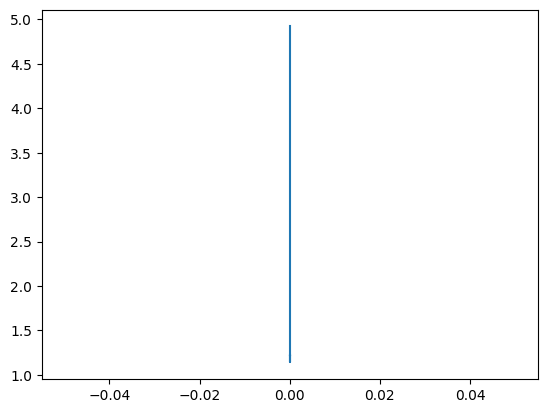

In [102]:
errors = []
for delta, n in zip(deltas, range(len(Ndeltas))):
    N = Ndeltas[n]
    M = Mdeltas[n]
    fine = fineDeltas[n]
    N = int(N)
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}.0_{M}.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}.0_{fine}.npy')
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    error = jnp.mean(jnp.linalg.norm(paths_1[:, -1] - paths_2[:, -1], axis=-1), axis=0)
    errors.append(error)
errors = jnp.array(errors)
plt.plot(jnp.log(Ndeltas), -jnp.log(errors))


In [103]:
linear_regressor = LinearRegression().fit(jnp.log(Ndeltas).reshape(-1, 1), -jnp.log(errors))
linear_regressor.coef_

array([0.], dtype=float32)

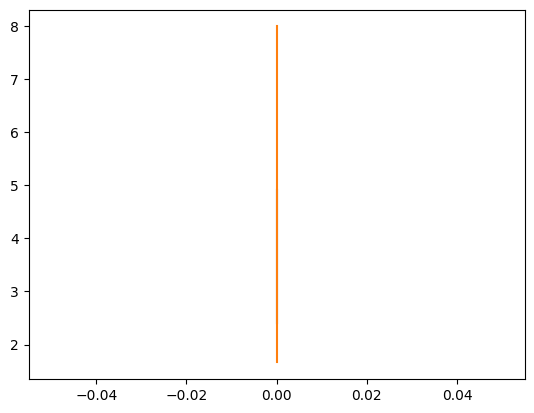

In [104]:
x0 = jnp.ones((2, ))
errors = []
errors2 = []
for n in range(len(deltas)):
    N = Ndeltas[n]
    M = Mdeltas[n]
    fine = fineDeltas[n]
    N = int(N)
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}.0_{M}.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}.0_{fine}.npy')
    paths = jnp.load(f'{folder}/{prefix}_paths_{N}.0_{fine}.npy')
    dt = 1 / paths.shape[1]
    k = int(paths.shape[1] / N)
    non_normalized_incs = paths / jnp.sqrt(dt)
    linspace = jnp.linspace(0, 1, N+1)
    B = jnp.cumsum(non_normalized_incs, axis=1)
    B = jnp.insert(B, 0, 0.0, axis=1)
    V = x0[1] + B
    intB = jnp.cumsum(B, axis=1) * dt
    V = V[:,::k,...]
    intB = intB[:,::k,...]
    U = x0[0] + x0[1]* linspace[1:].reshape((linspace.shape[0]-1)) + jnp.squeeze(intB[:,:-1], axis=-1)
    U = jnp.insert(U, 0, x0[0], axis=1)
    error = jnp.max(jnp.mean(jnp.abs(paths_2[:,:,0]-paths_1[:,:,0]), axis=0), axis=-1)
    error2 = jnp.max(jnp.abs(jnp.mean(paths_2[:,:,0]**2, axis=0)-jnp.mean(paths_1[:,:,0]**2, axis=0)), axis=-1)
    errors2.append(error2)
    errors.append(error)
errors = jnp.array(errors)
errors2 = jnp.array(errors2)
plt.plot(jnp.log(Ndeltas), -jnp.log(errors))
plt.plot(jnp.log(Ndeltas), -jnp.log(errors2))

In [35]:
linear_regressor = LinearRegression().fit(jnp.log(Ndeltas)[1:].reshape(-1, 1), -jnp.log(errors)[1:])
linear_regressor.coef_

array([0.], dtype=float32)

In [36]:
linear_regressor = LinearRegression().fit(jnp.log(Ndeltas)[1:].reshape(-1, 1), -jnp.log(errors2)[1:])
linear_regressor.coef_

array([0.], dtype=float32)

In [37]:
import jax
import jax.numpy as jnp
from functools import partial
@partial(jax.jit, static_argnums=(1, 2))
def lie(var, U, V):
    """
    Vector field Lie bracket.
    :param var: The Lie bracket will be evaluated at x = var.
    :param U: Numerical function.
    :param V: Numerical function.
    :return: The vector field Lie bracket [u, v] applied to Id, at x = var, [u, v](Id)(var).
    """
    jacU = jax.jacfwd(U)(var)
    jacV = jax.jacfwd(V)(var)
    return jacU @ V(var) - jacV @ U(var)


In [38]:
x = jnp.array([1.0, 1.0])

def drift(x):
    return jnp.array([[0.0, 1.0], [0.0, 0.0]]) @ x


def sigma(x):
    return jnp.array([[0.0], [1.0]])

lie(x, sigma, drift)

Array([[-1.],
       [ 0.]], dtype=float32)

In [39]:
lie(x, sigma, lambda z: lie(z, sigma, drift))

Array([[[0.]],

       [[0.]]], dtype=float32)

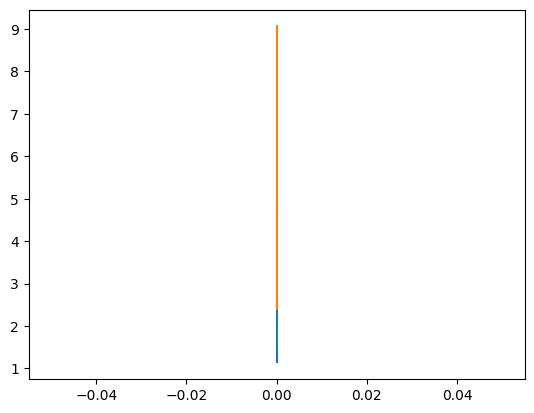

In [105]:
errors = []
errors2 = []
for delta, n in zip(deltas, range(len(Ndeltas))):
    N = Ndeltas[n]
    M = Mdeltas[n]
    fine = fineDeltas[n]
    N = int(N)
    paths_1 = jnp.load(f'{folder}/{prefix}_pathwise_sols_{N}.0_{M}.npy')
    paths_2 = jnp.load(f'{folder}/{prefix}_pathwise_sols2_{N}.0_{fine}.npy')
    N += 1
    assert N == len(paths_1[0]) == len(paths_2[0])
    error = jnp.mean(jnp.linalg.norm(paths_1[:, 1] - paths_2[:, 1], axis=-1), axis=0)
    error2 = jnp.abs(jnp.mean(paths_2[:,1,0]**1, axis=0)-jnp.mean(paths_1[:, 1,0]**1, axis=0))
    errors.append(error)
    errors2.append(error2)
errors = jnp.array(errors)
errors2 = jnp.array(errors2)
plt.plot(jnp.log(Ndeltas), -jnp.log(errors))
plt.plot(jnp.log(Ndeltas), -jnp.log(errors2))


In [93]:
linear_regressor = LinearRegression().fit(jnp.log(Ndeltas)[1:].reshape(-1, 1), -jnp.log(errors)[1:])
linear_regressor.coef_

array([0.], dtype=float32)

In [94]:
linear_regressor = LinearRegression().fit(jnp.log(Ndeltas)[1:].reshape(-1, 1), -jnp.log(errors2)[1:])
linear_regressor.coef_

array([0.], dtype=float32)

In [111]:
errors

Array([0.29400223, 0.2945037 , 0.29640117, 0.29605815, 0.29776606,
       0.30089942, 0.3025391 , 0.31255835, 0.32031173, 0.0072892 ],      dtype=float32)

In [114]:
errors2

Array([0.08990943, 0.0887866 , 0.08738041, 0.08561027, 0.08320057,
       0.07989538, 0.07484639, 0.06653905, 0.04991579, 0.00011623],      dtype=float32)

In [118]:
paths_2[:, 1, 0].var()*3/delta**3

Array(1.0200636, dtype=float32)

In [119]:
paths_1[:, 1, 0].var()*3/delta**3

Array(0.7779164, dtype=float32)

In [107]:
paths_1[0]

Array([[1.       , 1.       ],
       [1.0756154, 0.5123087]], dtype=float32)

In [109]:
paths_2[0]

Array([[1.       , 1.       ],
       [1.0676763, 0.5119021]], dtype=float32)

In [108]:
1+0.1+0.1**2

1.11

In [83]:
delta

Array(0.1, dtype=float32)

In [100]:
paths.std()

Array(0.31612253, dtype=float32)